In [29]:
import pandas as pd
from rdkit import (Chem, DataStructs, Geometry)
from rdkit.Chem import (Descriptors,
    Lipinski, QED, Draw, AllChem, PandasTools, rdFingerprintGenerator)
import json
from kinfraglib import utils
import matplotlib.pyplot as plt
import seaborn as sns
import utils_eval
import math
from copy import deepcopy
from rdkit.ML.Cluster import Butina
import numpy as np
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm


In [30]:
chembl_most_similar = pd.read_csv('chembl_most_similar_rdkit.csv')

In [31]:
chembl_most_similar['ROMol'] = chembl_most_similar['inchi'].map(AllChem.MolFromInchi)

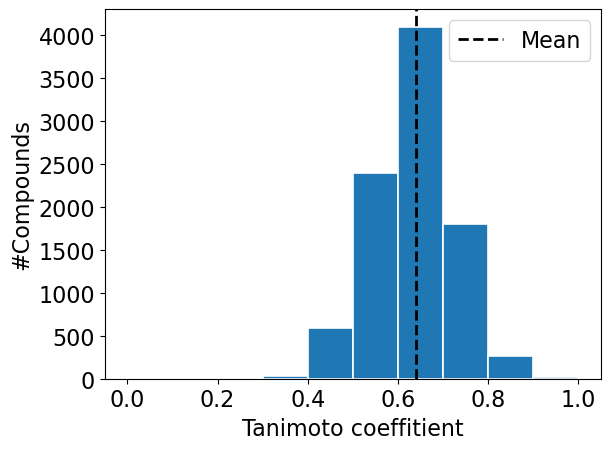

In [32]:
ax = chembl_most_similar['most_similar_chembl_ligand.similarity'].plot(
    kind='hist', 
    bins=np.arange(0, 1.1, 0.1), 
    edgecolor='white', 
    linewidth=1.2
)
ax.set_xlabel('Tanimoto coeffitient', fontsize=16)
ax.set_ylabel('#Compounds', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
mean_line = plt.axvline(chembl_most_similar['most_similar_chembl_ligand.similarity'].mean(), color='k', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(handles = [mean_line], fontsize=16)
plt.show()

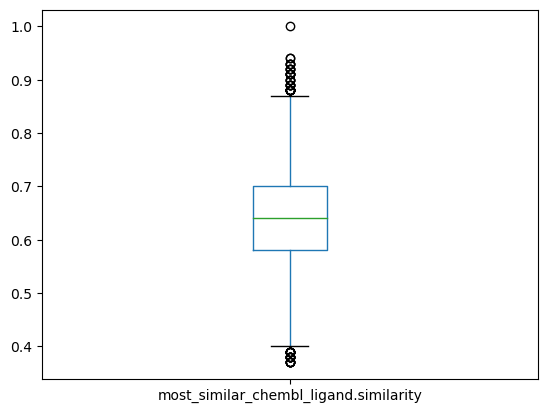

In [33]:
chembl_most_similar['most_similar_chembl_ligand.similarity'].plot(kind='box')
plt.show()

In [34]:
print(f'Number of ligands with similarity of 1.0 to at least one ChEMBL molecule:')
chembl_most_similar[chembl_most_similar['most_similar_chembl_ligand.similarity'] == 1.0].shape[0]

Number of ligands with similarity of 1.0 to at least one ChEMBL molecule:


1

In [35]:
print(f'Number of ligands with similarity of more than 0.9 to at least one ChEMBL molecule:')
print(chembl_most_similar[chembl_most_similar['most_similar_chembl_ligand.similarity'] >= 0.9].shape[0])
most_similar = chembl_most_similar[chembl_most_similar['most_similar_chembl_ligand.similarity'] > 0.9].sort_values('most_similar_chembl_ligand.compound_id', ascending=False)

Number of ligands with similarity of more than 0.9 to at least one ChEMBL molecule:
21


In [36]:
sum(most_similar["most_similar_chembl_ligand.compound_id"].duplicated())

8

In [37]:
# get these compounds
compounds_api = new_client.molecule
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(most_similar["most_similar_chembl_ligand.compound_id"])
).only("molecule_chembl_id", "molecule_structures")



compounds = list(tqdm(compounds_provider))



compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")


  0%|          | 0/9 [00:00<?, ?it/s]

DataFrame shape: (9, 2)


In [38]:
# compounds_df.set_index('molecule_chembl_id', inplace=True)

In [39]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=2,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

In [40]:
# print most common scaffolds
from PIL import Image 
from rdkit.Chem import rdFMCS
for id in compounds_df.index:
    mol_chembl = [AllChem.MolFromSmiles(compounds_df['molecule_structures'][id]['canonical_smiles'])]
    chembl_id = compounds_df['molecule_chembl_id'][id]
    mol_chembl[0].SetProp('_Name', chembl_id)
    print(chembl_id)
    print(most_similar[most_similar['most_similar_chembl_ligand.compound_id'] == chembl_id]['most_similar_chembl_ligand.similarity'].iloc[0])
    mols = mol_chembl + [most_similar[most_similar['most_similar_chembl_ligand.compound_id'] == chembl_id]['ROMol'].iloc[0]]
    mcs1 = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True)
    m1 = Chem.MolFromSmarts(mcs1.smartsString)
    for i, mol in enumerate(mols):
        AllChem.Compute2DCoords(mol)
        if i:
            mol.SetProp('_Name', "")
    """img = Draw.MolsToGridImage(
        mols, 
        molsPerRow=5, 
        maxMols=100,
        subImgSize=(300, 300)
    )"""  
    img = highlight_molecules(mols, mcs1, len(mols), useSVG=False, same_orientation=False)
    print(type(img))
    with open(f"{chembl_id}.png", "wb") as png:
        png.write(img.data)
    #Draw.MolToFile(mols[0], f'{chembl_id}.png') 
    #Draw.MolToFile(mols[1], f'{chembl_id}_compound.png')
    #Draw.MolToFile(m1, f'{chembl_id}_mcs.png')

    # Set background to transparent & Enlarge size of label
    # molsvg = molsvg.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

CHEMBL1394527
0.91
<class 'IPython.core.display.Image'>
CHEMBL1479093
0.93
<class 'IPython.core.display.Image'>
CHEMBL2017552
1.0
<class 'IPython.core.display.Image'>
CHEMBL4519540
0.91
<class 'IPython.core.display.Image'>
CHEMBL4904571
0.94
<class 'IPython.core.display.Image'>
CHEMBL4929913
0.93
<class 'IPython.core.display.Image'>
CHEMBL4968621
0.91
<class 'IPython.core.display.Image'>
CHEMBL4973610
0.93
<class 'IPython.core.display.Image'>
CHEMBL4991843
0.92
<class 'IPython.core.display.Image'>


In [41]:
print(f'Mean similarity to nearest chembl compound: {chembl_most_similar["most_similar_chembl_ligand.similarity"].describe()}')

Mean similarity to nearest chembl compound: count    9194.000000
mean        0.639367
std         0.089263
min         0.370000
25%         0.580000
50%         0.640000
75%         0.700000
max         1.000000
Name: most_similar_chembl_ligand.similarity, dtype: float64


In [42]:
# show exact matches
chembl_most_similar[chembl_most_similar['most_similar_chembl_ligand.similarity'] == 1.0]

,Unnamed: 0,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,BIOSOLVEIT.DOCKING_SCORE,filtered,num_fragments,binding_affinity,inchi,most_similar_chembl_ligand.compound_id,most_similar_chembl_ligand.similarity
738,738,"<img data-content=""rdkit/molecule"" src=""data:i...",11.381083,1130.777912,4.0001,297.38,64.7,"{'AP': 208, 'SE': 262}",CC(C)(O)c1ccc2cc(-c3n[nH]c4ccsc34)[nH]c2c1,"{'AP': 'c1cc2[nH]ncc2s1', 'SE': '[25*]c1cc2ccc...","{'AP': '[51*]c1n[nH]c2ccsc12', 'SE': 'CC(C)(O)...",45.96,1,2,571.079498,"InChI=1S/C16H15N3OS/c1-16(2,20)10-4-3-9-7-13(1...",CHEMBL2017552,1.0
